# Realtime Face Emotion Recognition

## Import Package

In [1]:
import tensorflow as tf
import cv2
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.models import Model

## Unzip Dataset

In [ ]:
local_file = 'Dataset.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

## Loading and Preprocessing the Dataset

In [ ]:
# Reducing data set
dataset_path = "data"

# Set the path to the directory where you want to store the reduced dataset
reduced_dataset_path = "ReducedData"

# Set the desired number of samples for each class
samples_per_class = 400

# Iterate through each class (emotion)
for emotion in os.listdir(dataset_path + "/train"):
    # Create the destination directory for the reduced dataset
    os.makedirs(os.path.join(reduced_dataset_path, "train", emotion), exist_ok=True)

    # Get the list of image files for the current emotion
    images = os.listdir(os.path.join(dataset_path, "train", emotion))

    # Randomly sample the desired number of images
    selected_images = random.sample(images, samples_per_class)

    # Copy the selected images to the reduced dataset directory
    for image in selected_images:
        src_path = os.path.join(dataset_path, "train", emotion, image)
        dest_path = os.path.join(reduced_dataset_path, "train", emotion, image)
        shutil.copy(src_path, dest_path)

In [2]:
#Define Directory
train_dir =  "ReducedData/train/"
test_dir = "data/test/"

In [3]:
#Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    validation_split = .2
)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=.2)

img_size = 224
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

test_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [4]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Building the CNN Model

In [ ]:
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(img_size, img_size, 1), activation='relu'),
#    tf.keras.layers.MaxPooling2D((2, 2)),
#    tf.keras.layers.BatchNormalization(),
#
#    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#    tf.keras.layers.MaxPooling2D((2, 2)),
#    tf.keras.layers.BatchNormalization(),
#
#    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#    tf.keras.layers.MaxPooling2D((2, 2)),
#    tf.keras.layers.BatchNormalization(),
#
#    tf.keras.layers.Flatten(),
#
#    tf.keras.layers.Dense(128, activation="relu"),
#    tf.keras.layers.Dropout(.2),
#    tf.keras.layers.Dense(64, activation="relu"),
#    tf.keras.layers.Dropout(.2),
#    tf.keras.layers.Dense(32, activation="relu"),
#    tf.keras.layers.Dropout(.2),
#
#    tf.keras.layers.Dense(7, activation="softmax")
#])
#
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")
#checkpointer_model=tf.keras.callbacks.ModelCheckpoint("FER_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1)
#history = model.fit(train_generator, epochs=60, validation_data=test_generator, callbacks=[checkpointer_model], verbose=2)

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
        layer.trainable = False
        
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output_layer = tf.keras.layers.Dense(7, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output_layer)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")
checkpointer_model=tf.keras.callbacks.ModelCheckpoint("FER_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1)
history = model.fit(train_generator, epochs=60, validation_data=test_generator, callbacks=[checkpointer_model], verbose=2)

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.27321, saving model to FER_model.h5
140/140 - 21s - loss: 1.9715 - accuracy: 0.2384 - val_loss: 1.8098 - val_accuracy: 0.2732 - 21s/epoch - 149ms/step
Epoch 2/60

Epoch 2: val_accuracy improved from 0.27321 to 0.37321, saving model to FER_model.h5
140/140 - 17s - loss: 1.6784 - accuracy: 0.3487 - val_loss: 1.6559 - val_accuracy: 0.3732 - 17s/epoch - 124ms/step
Epoch 3/60

Epoch 3: val_accuracy did not improve from 0.37321
140/140 - 18s - loss: 1.5561 - accuracy: 0.4045 - val_loss: 1.6641 - val_accuracy: 0.3571 - 18s/epoch - 131ms/step
Epoch 4/60

Epoch 4: val_accuracy improved from 0.37321 to 0.38036, saving model to FER_model.h5
140/140 - 18s - loss: 1.4932 - accuracy: 0.4321 - val_loss: 1.5866 - val_accuracy: 0.3804 - 18s/epoch - 127ms/step
Epoch 5/60

Epoch 5: val_accuracy did not improve from 0.38036
140/140 - 17s - loss: 1.3717 - accuracy: 0.4929 - val_loss: 1.5850 - val_accuracy: 0.3786 - 17s/epoch - 119ms/step
Epoch 6/60


## Loss and Accuracy

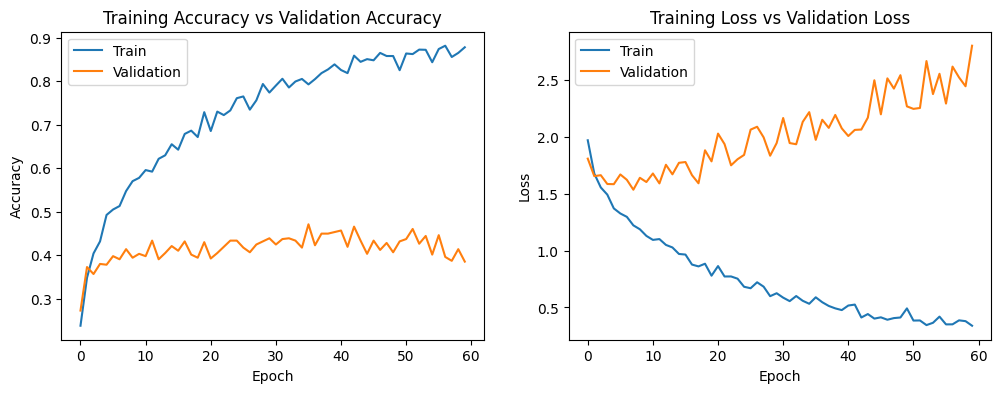

In [8]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()